<div align="center">

# **<span>Task 1: MLP (Multilayer Perceptron)</span>**

</div>
In this task, we built an MLP model to predict football match results using a dataset from the Road to Qatar 2022 and the actual World Cup matches. We began by exploring and cleaning the data, excluding columns like team names and goals to prevent bias and leakage.

We used only qualifier matches to train our model and kept World Cup matches for final prediction. After preprocessing (label encoding, standardization, and tensor conversion), we defined and trained an MLP using PyTorch with cross-entropy loss and an optimizer over multiple epochs.

We evaluated the model's accuracy on the test set and finally used it to simulate and predict the outcomes of the FIFA World Cup 2022, including both group and knockout stages.

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = [15, 10]

np.random.seed(42)
torch.manual_seed(42)

# **1. Dataset Loading**

In [119]:
df = pd.read_csv('matches.csv')

In [120]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,Spain,1,0,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,Portugal,1,0,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,Northern Ireland,7,0,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1
3,Italy,4,2,Switzerland,0,-438.0,-120.0,-259.0,-59.0,-595.0,-936.0,46.0,33.0,0.0,13.0,78.0,13.0,1
4,Portugal,2,0,France,0,-191.0,-101.0,-61.0,-29.0,-388.0,-353.0,-36.0,-20.0,-9.0,-7.0,-71.0,-42.0,1


# **2. EDA (Exploratory Data Analysis)**

## **Overall Structure**

### - Number of Rows and Columns

In [121]:
print(f"Number of rows: {len(df)}")

Number of rows: 17812


In [122]:
print(f"Number of columns: {len(df.columns)}")

Number of columns: 18


### - Data Types

In [123]:
df.dtypes

home_team                object
home_goals                int64
away_goals                int64
away_team                object
wcm                       int64
dif_inter_match         float64
dif_inter_match_won     float64
dif_inter_match_lost    float64
dif_inter_match_tie     float64
dif_inter_goals_sco     float64
dif_inter_goals_con     float64
dif_wc_match            float64
dif_wc_match_won        float64
dif_wc_match_lost       float64
dif_wc_match_tied       float64
dif_wc_goals_sco        float64
dif_wc_goals_con        float64
status                    int64
dtype: object

### - Missing Values

In [124]:
df.isna().sum()

home_team               0
home_goals              0
away_goals              0
away_team               0
wcm                     0
dif_inter_match         0
dif_inter_match_won     0
dif_inter_match_lost    0
dif_inter_match_tie     0
dif_inter_goals_sco     0
dif_inter_goals_con     0
dif_wc_match            0
dif_wc_match_won        0
dif_wc_match_lost       0
dif_wc_match_tied       0
dif_wc_goals_sco        0
dif_wc_goals_con        0
status                  0
dtype: int64

### - Distribution of Features

In [125]:
df.columns

Index(['home_team', 'home_goals', 'away_goals', 'away_team', 'wcm',
       'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con', 'status'],
      dtype='object')

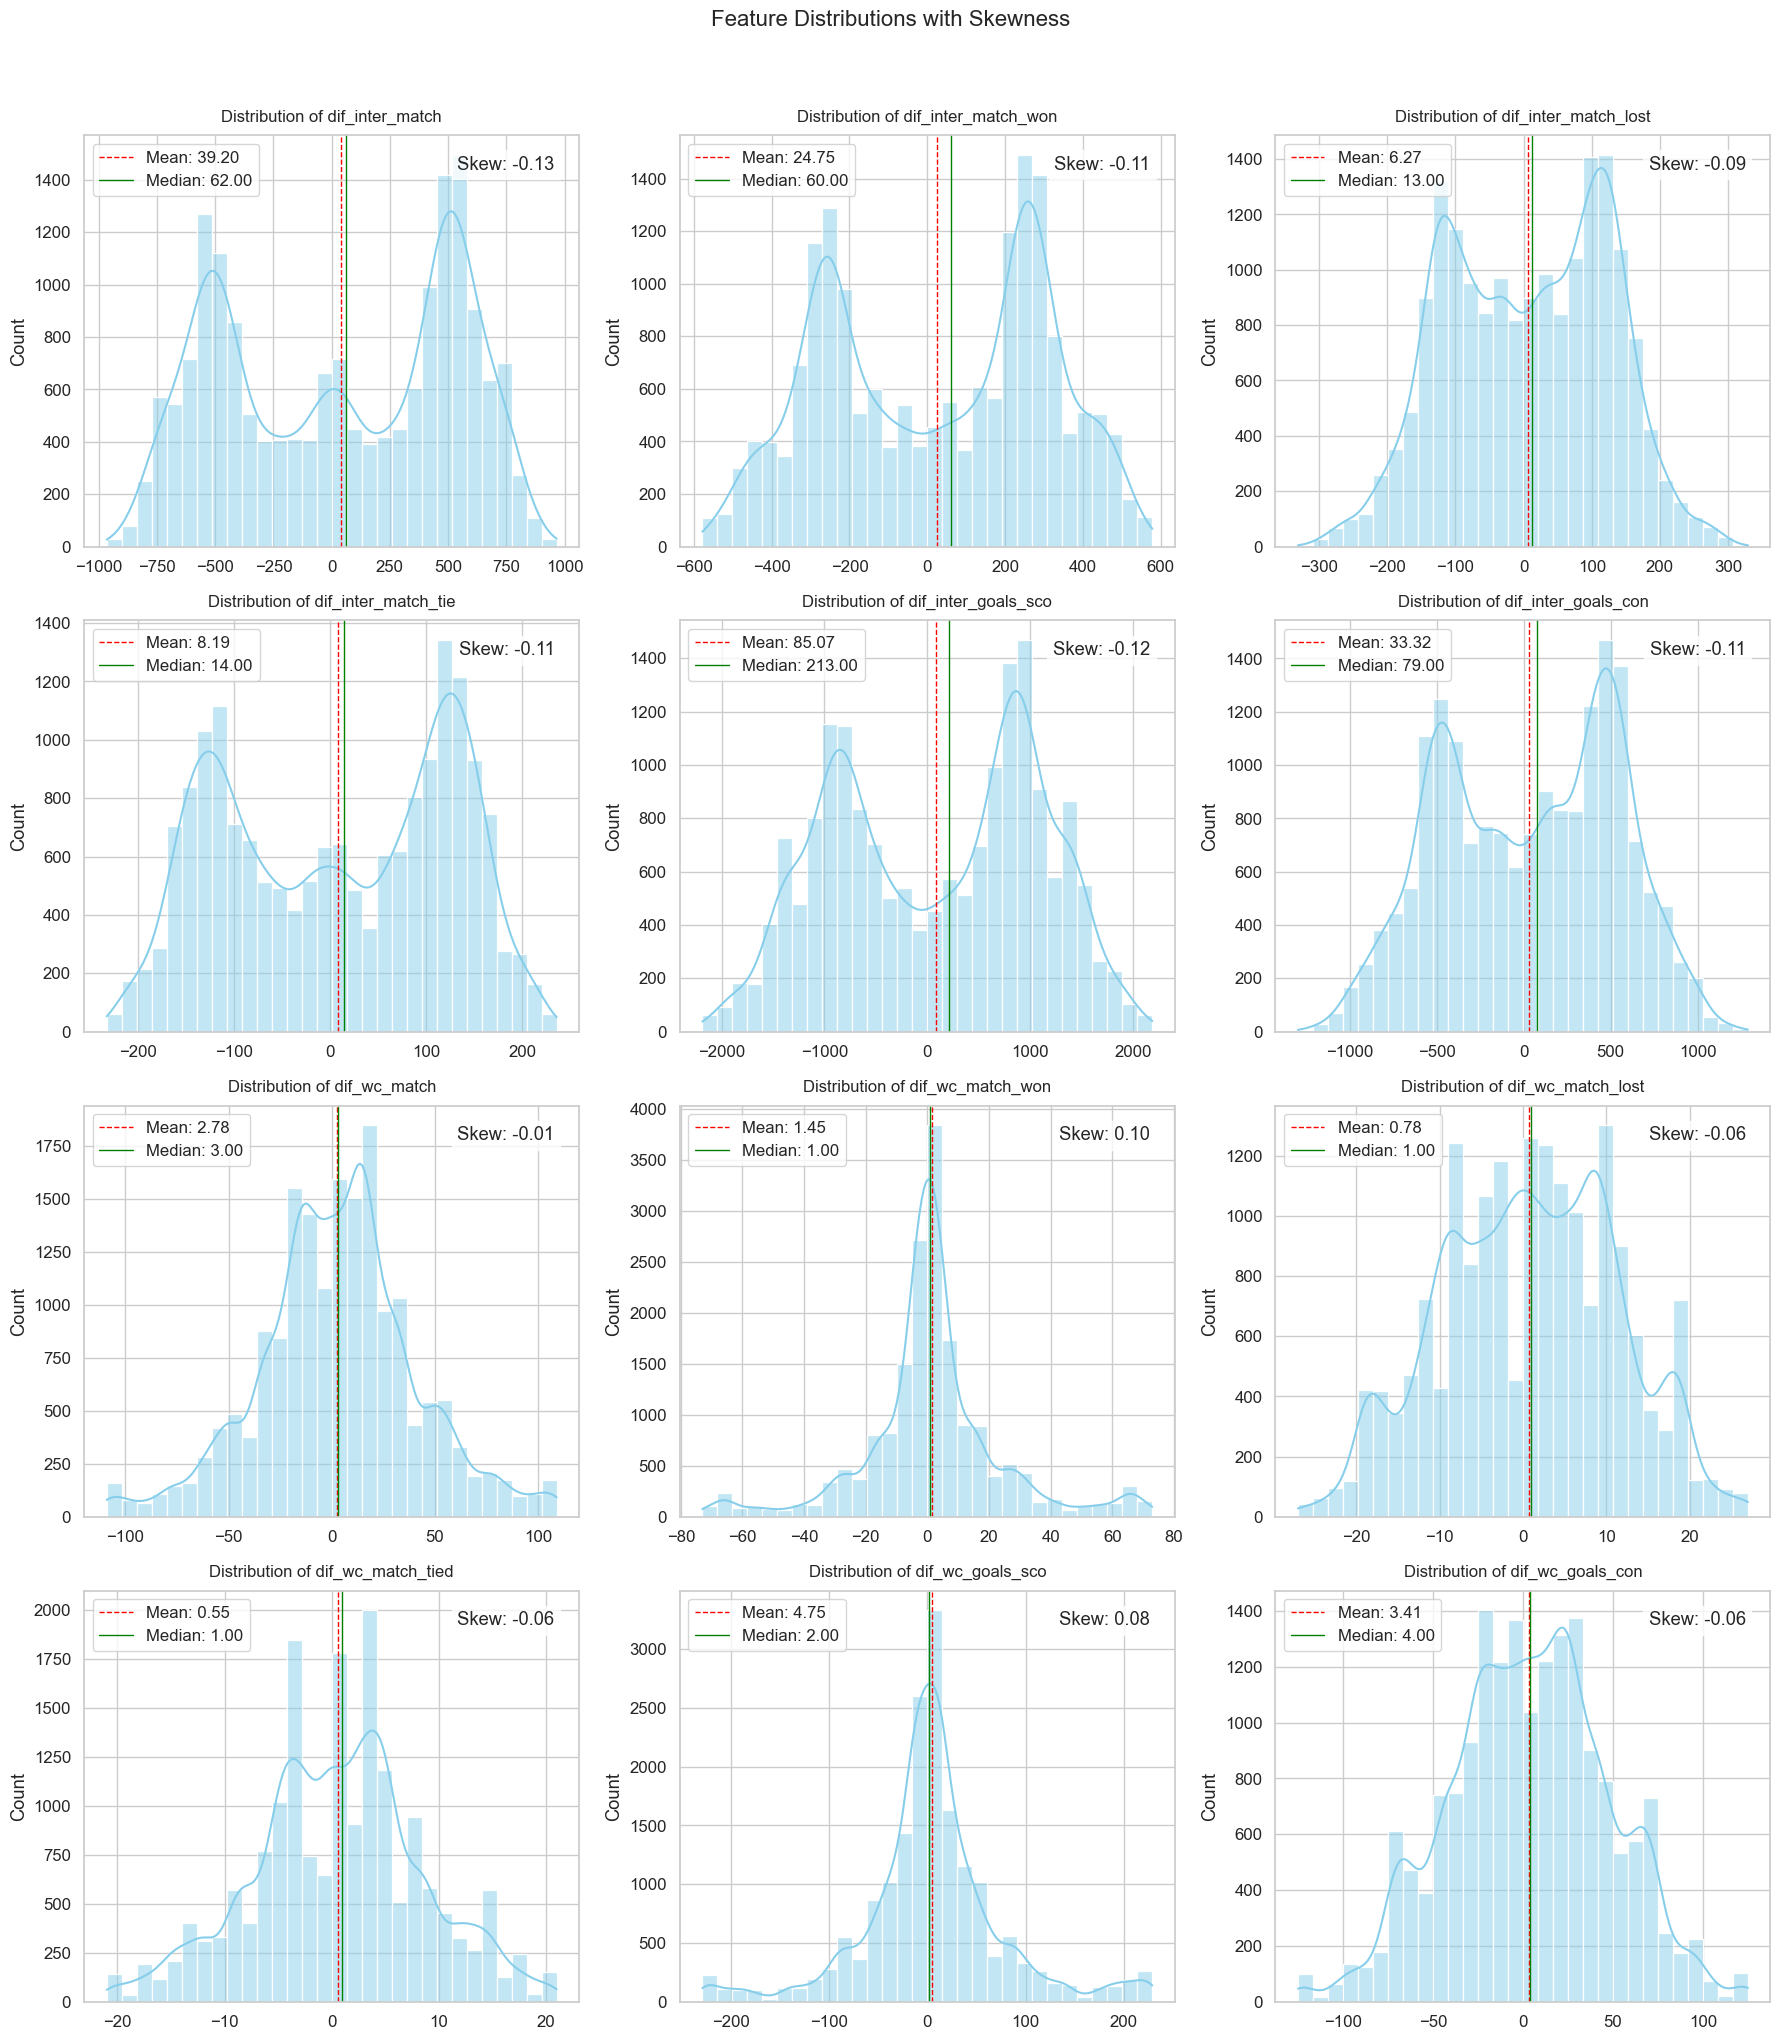

In [ ]:
features_to_analyze = [
    'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
    'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
    'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
    'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con'
]

n_cols = 3
n_rows = (len(features_to_analyze) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features_to_analyze):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i], bins=30, color='skyblue')
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='-', linewidth=1, label=f'Median: {median_val:.2f}')
    axes[i].set_title(f'Distribution of {feature}', fontsize=12, pad=10)
    axes[i].set_xlabel('')
    axes[i].legend()

    skewness = stats.skew(df[feature].dropna())
    axes[i].text(0.95, 0.95, f'Skew: {skewness:.2f}',
                 transform=axes[i].transAxes, ha='right', va='top',
                 bbox=dict(facecolor='white', alpha=0.8))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Feature Distributions with Skewness', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### - Target Variable Analysis

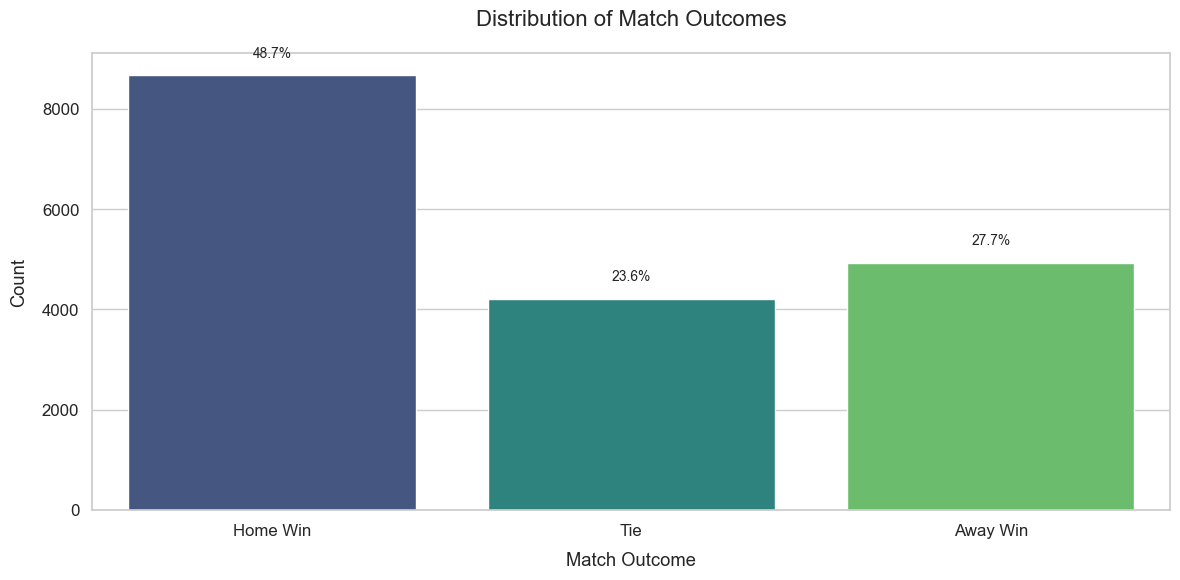


Outcome Distribution Statistics:
status
Home Win    8674
Away Win    4927
Tie         4211
Name: count, dtype: int64


In [ ]:
status_labels = {1: 'Home Win', 2: 'Tie', 3: 'Away Win'}

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='status', data=df, palette='viridis')
plt.title('Distribution of Match Outcomes', fontsize=16, pad=20)
plt.xlabel('Match Outcome', labelpad=10)
plt.ylabel('Count', labelpad=10)

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 0.02*total
    ax.annotate(percentage, (x, y), ha='center', fontsize=10)

ax.set_xticklabels([status_labels[int(t.get_text())] for t in ax.get_xticklabels()])
plt.tight_layout()
plt.show()

print("\nOutcome Distribution Statistics:")
print(df['status'].value_counts().rename(index=status_labels))

### - Feature Relationships

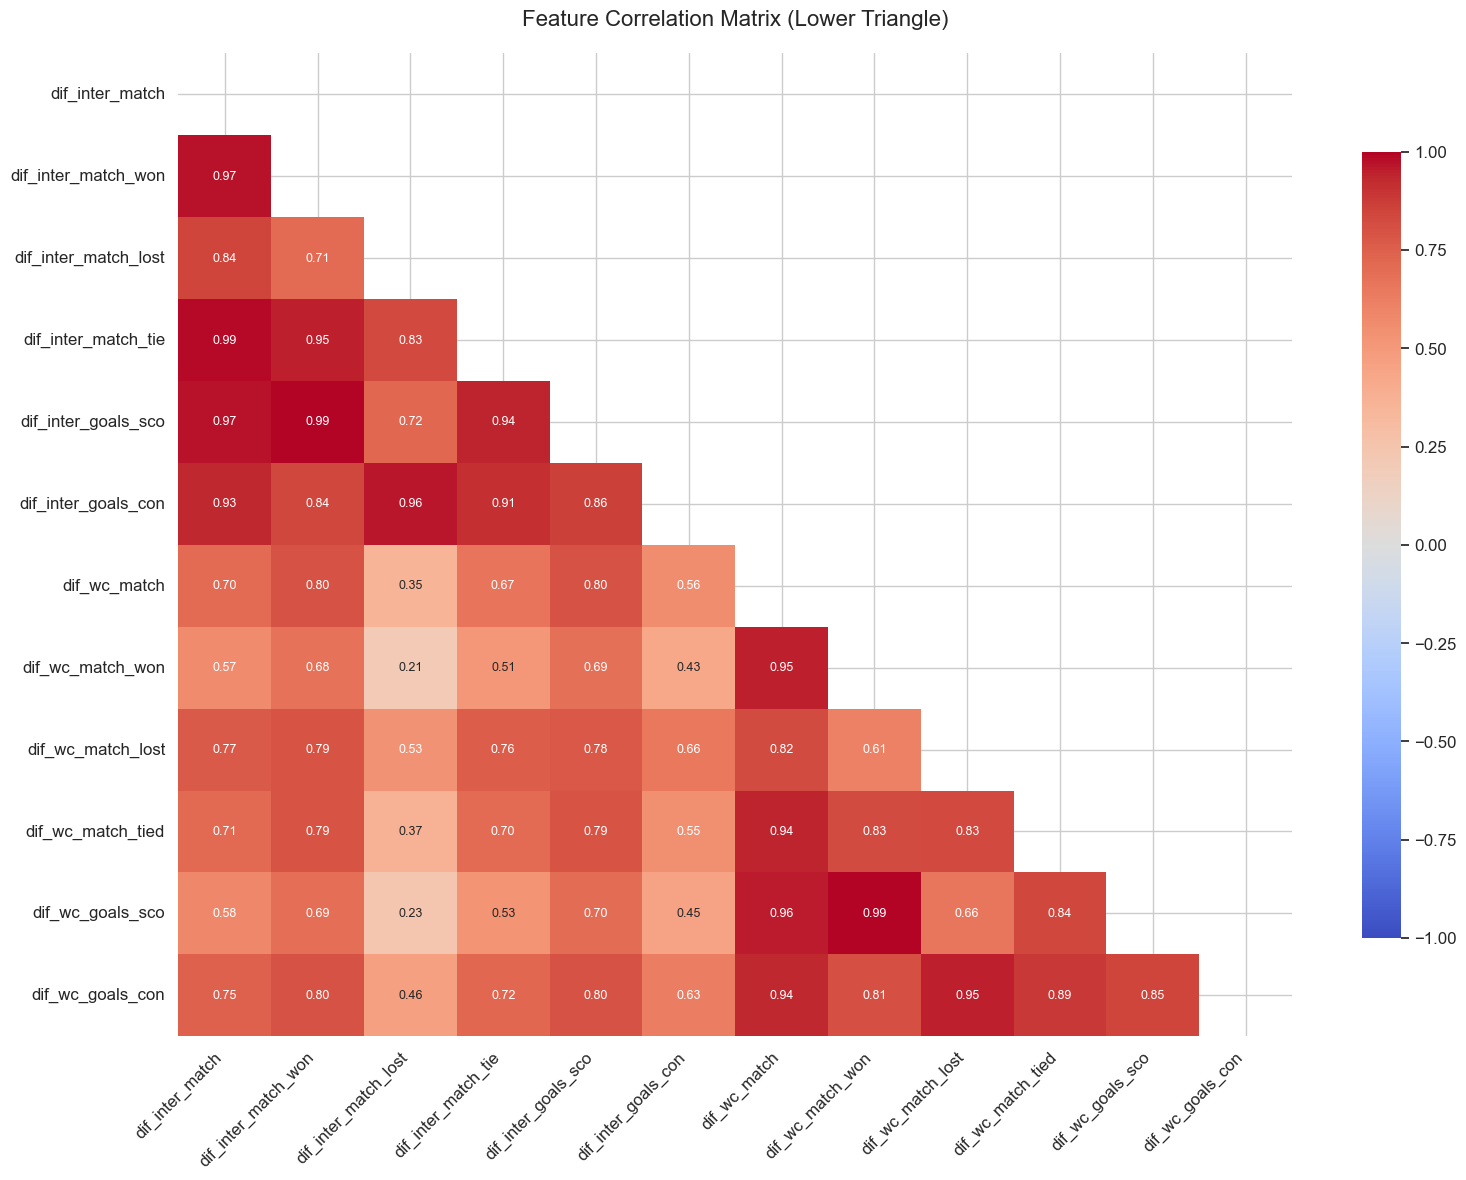

In [ ]:
plt.figure(figsize=(16, 12))
corr = df[features_to_analyze].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, cbar_kws={'shrink': 0.8},
            annot_kws={'size': 9})
plt.title('Feature Correlation Matrix (Lower Triangle)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### - World Cup vs Qualifier Comparison

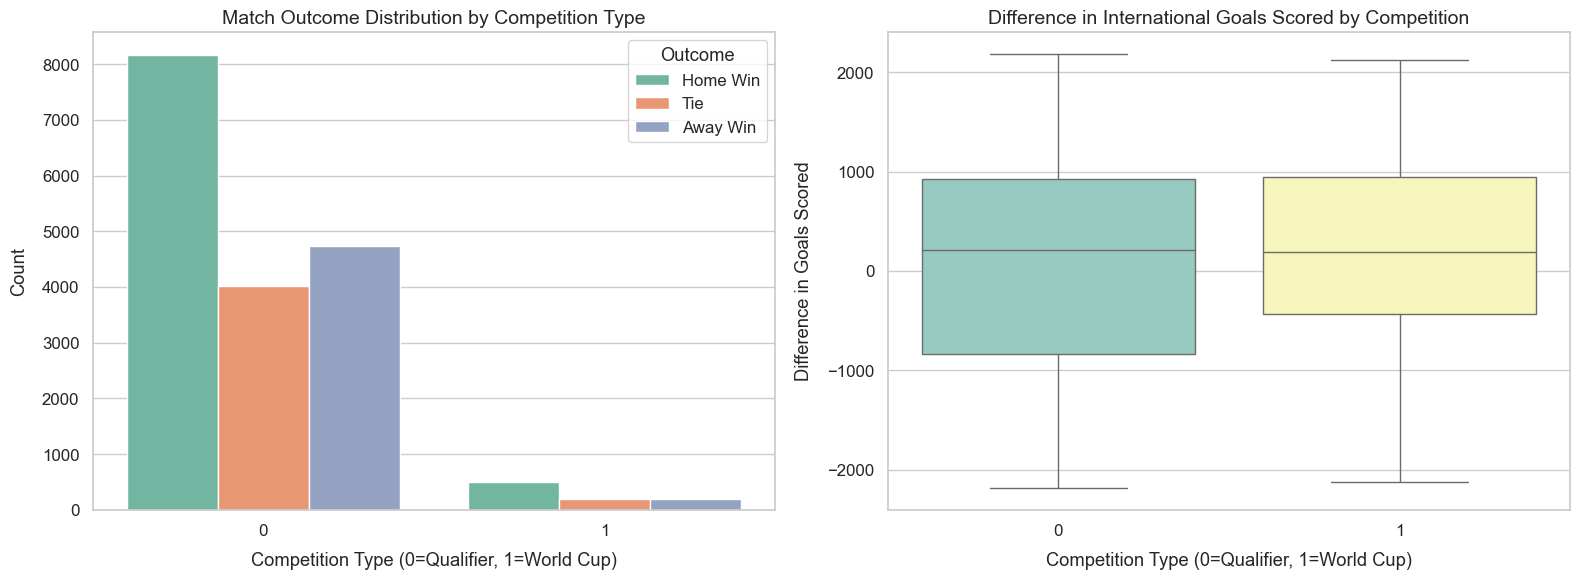

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=df, x='wcm', hue='status', palette='Set2', ax=axes[0])
axes[0].set_title('Match Outcome Distribution by Competition Type', fontsize=14)
axes[0].set_xlabel('Competition Type (0=Qualifier, 1=World Cup)', labelpad=10)
axes[0].set_ylabel('Count', labelpad=10)
axes[0].legend(title='Outcome', labels=[status_labels[k] for k in sorted(status_labels.keys())])

sns.boxplot(data=df, x='wcm', y='dif_inter_goals_sco', palette='Set3', ax=axes[1])
axes[1].set_title('Difference in International Goals Scored by Competition', fontsize=14)
axes[1].set_xlabel('Competition Type (0=Qualifier, 1=World Cup)', labelpad=10)
axes[1].set_ylabel('Difference in Goals Scored', labelpad=10)

plt.tight_layout()
plt.show()

### - Skewness and Transformation

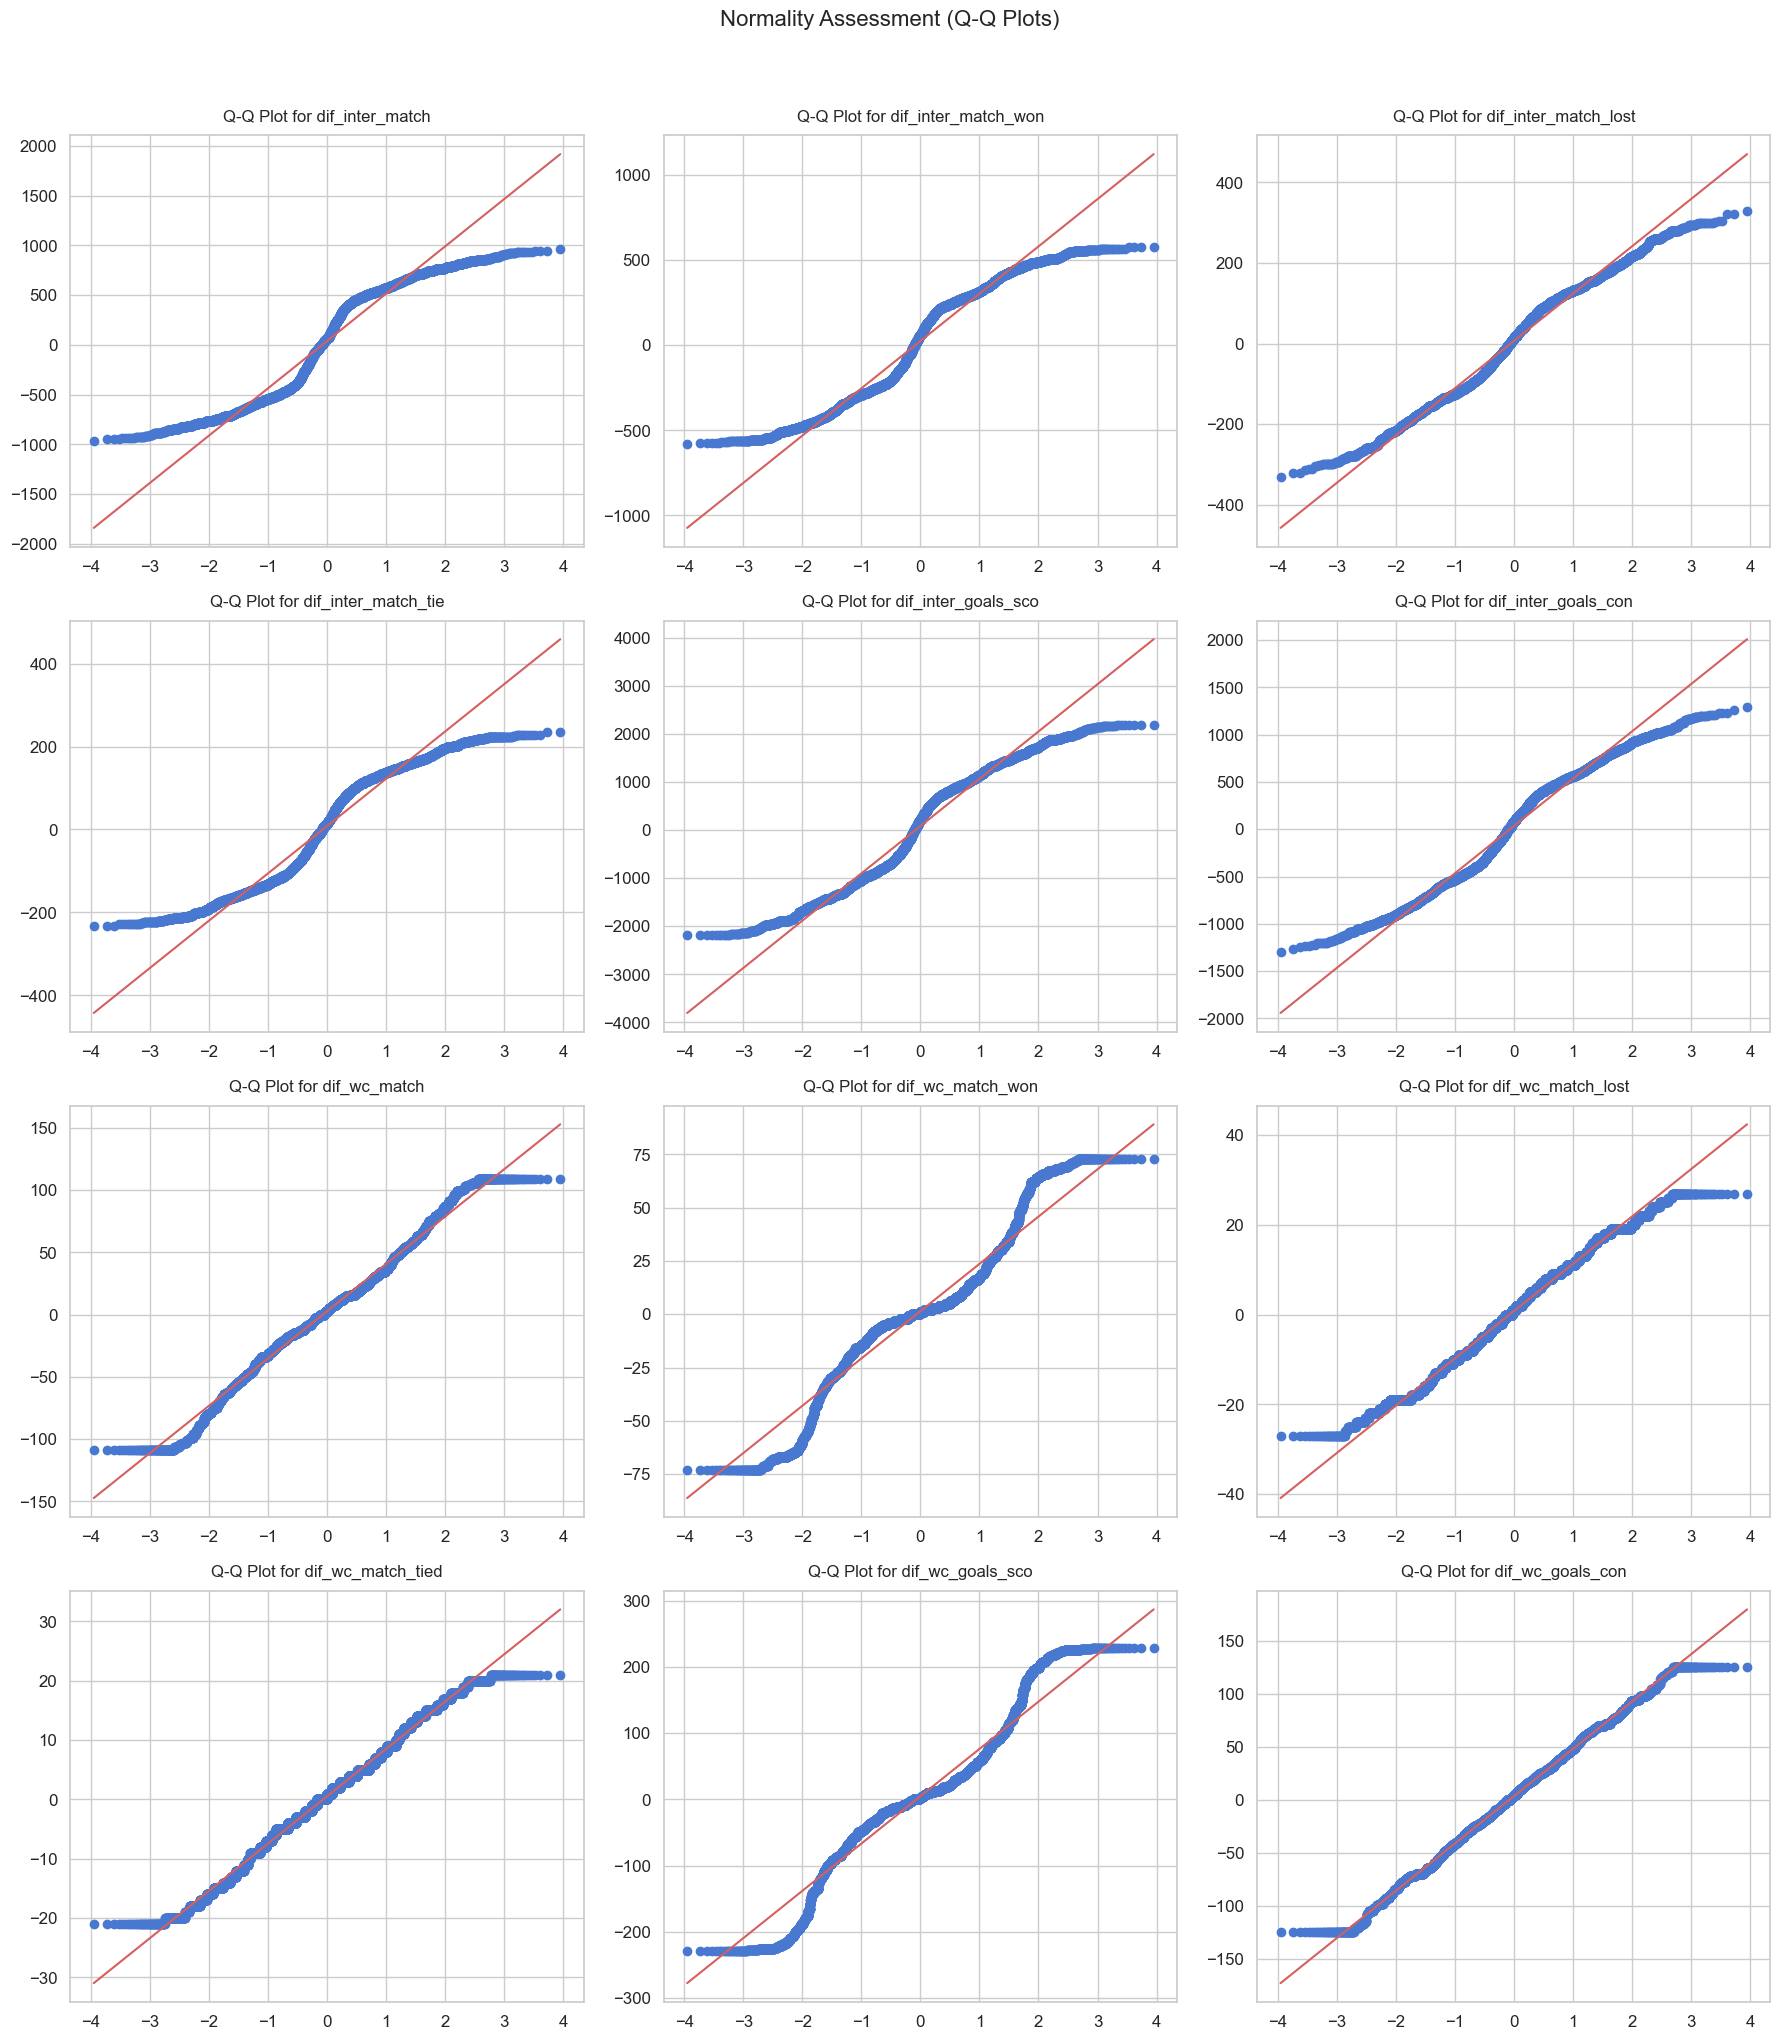


Scaling Recommendations:
- dif_inter_match: Fairly symmetric (skew=-0.13), scaling may still be beneficial
- dif_inter_match_won: Fairly symmetric (skew=-0.11), scaling may still be beneficial
- dif_inter_match_lost: Fairly symmetric (skew=-0.09), scaling may still be beneficial
- dif_inter_match_tie: Fairly symmetric (skew=-0.11), scaling may still be beneficial
- dif_inter_goals_sco: Fairly symmetric (skew=-0.12), scaling may still be beneficial
- dif_inter_goals_con: Fairly symmetric (skew=-0.11), scaling may still be beneficial
- dif_wc_match: Fairly symmetric (skew=-0.01), scaling may still be beneficial
- dif_wc_match_won: Fairly symmetric (skew=0.10), scaling may still be beneficial
- dif_wc_match_lost: Fairly symmetric (skew=-0.06), scaling may still be beneficial
- dif_wc_match_tied: Fairly symmetric (skew=-0.06), scaling may still be beneficial
- dif_wc_goals_sco: Fairly symmetric (skew=0.08), scaling may still be beneficial
- dif_wc_goals_con: Fairly symmetric (skew=-0.06),

In [ ]:
n_cols = 3
n_rows = (len(features_to_analyze) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features_to_analyze):
    stats.probplot(df[feature].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {feature}', fontsize=12, pad=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Normality Assessment (Q-Q Plots)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

print("\nScaling Recommendations:")
for feature in features_to_analyze:
    skewness = stats.skew(df[feature].dropna())
    if abs(skewness) > 1:
        print(f"- {feature}: Highly skewed (skew={skewness:.2f}), consider power transformation before scaling")
    elif abs(skewness) > 0.5:
        print(f"- {feature}: Moderately skewed (skew={skewness:.2f}), consider scaling")
    else:
        print(f"- {feature}: Fairly symmetric (skew={skewness:.2f}), scaling may still be beneficial")


# **3. Data Preparation**

### - Filter World Cup Matches

In [131]:
train_df = df[df['wcm'] == 0].copy() 
wc_df = df[df['wcm'] == 1].copy()

print(f"Training set size: {len(train_df)}")
print(f"World Cup set size: {len(wc_df)}")

Training set size: 16912
World Cup set size: 900


### - Select Features (X) and Target (y)

In [132]:
excluded_cols = ['home_team', 'home_goals', 'away_goals', 'away_team', 'status']

y = train_df['status']
X = train_df.drop(excluded_cols, axis=1)

wc_df_y = wc_df['status']
wc_df_X = wc_df.drop(excluded_cols, axis=1)

### - Encode Labels

In [133]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
wc_y_encoded = le.transform(wc_df_y)

### - Train-Test Split (30% test)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded 
)

### - Standardization (StandardScaler)

In [135]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 
X_wc_scaled = scaler.transform(wc_df_X)

### - Convert to PyTorch Tensors

In [136]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)
X_wc_tensor = torch.FloatTensor(X_wc_scaled)
y_wc_tensor = torch.LongTensor(wc_y_encoded)

In [137]:
print("\nFinal Tensor Shapes:")
print(f"Training features: {X_train_tensor.shape}")
print(f"Training labels: {y_train_tensor.shape}")
print(f"Test features: {X_test_tensor.shape}")
print(f"Test labels: {y_test_tensor.shape}")
print(f"World Cup features: {X_wc_tensor.shape}")
print(f"World Cup labels: {y_wc_tensor.shape}")

print("\nFeature value ranges after StandardScaler:")
print(f"Training set min/max: {X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}")
print(f"Test set min/max: {X_test_tensor.min():.2f}, {X_test_tensor.max():.2f}")
print(f"World Cup scaled range: {X_wc_tensor.min():.2f}, {X_wc_tensor.max():.2f}")


Final Tensor Shapes:
Training features: torch.Size([11838, 13])
Training labels: torch.Size([11838])
Test features: torch.Size([5074, 13])
Test labels: torch.Size([5074])
World Cup features: torch.Size([900, 13])
World Cup labels: torch.Size([900])

Feature value ranges after StandardScaler:
Training set min/max: -3.26, 3.16
Test set min/max: -3.26, 3.16
World Cup scaled range: -3.26, 3.16


# **4. Model Definition**

In [138]:
class FootballPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FootballPredictor, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))

        self.output = nn.Linear(hidden_dims[-1], output_dim)
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Reduces overfitting
        
    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
            x = self.dropout(x)
        x = self.output(x)  # No softmax (included in CrossEntropyLoss)
        return x

In [139]:
input_dim = X_train_tensor.shape[1] 
output_dim = len(torch.unique(y_train_tensor))
hidden_dims = [64, 32]

model = FootballPredictor(input_dim, hidden_dims, output_dim)
print(model)

FootballPredictor(
  (layers): ModuleList(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


the current hidden layer is [64, 32]:
- Not too big (less likely to overfit)
- Not too small (can still learn useful patterns)

# **5. Model Training**

### - Training parameters

In [140]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
batch_size = 32

### - Create DataLoader for batching

In [141]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

### - Train Model

In [142]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    model.eval() 
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted_test = torch.max(test_outputs.data, 1)
        correct_test = (predicted_test == y_test_tensor).sum().item()
        test_accuracy = 100 * correct_test / y_test_tensor.size(0)
        
        test_losses.append(test_loss.item())
        test_acc.append(test_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

Epoch [10/100], Train Loss: 0.9532, Test Loss: 0.9449, Train Acc: 56.16%, Test Acc: 56.48%
Epoch [20/100], Train Loss: 0.9493, Test Loss: 0.9418, Train Acc: 56.03%, Test Acc: 56.70%
Epoch [30/100], Train Loss: 0.9468, Test Loss: 0.9413, Train Acc: 56.55%, Test Acc: 56.54%
Epoch [40/100], Train Loss: 0.9435, Test Loss: 0.9410, Train Acc: 56.46%, Test Acc: 57.21%
Epoch [50/100], Train Loss: 0.9455, Test Loss: 0.9425, Train Acc: 56.66%, Test Acc: 56.37%
Epoch [60/100], Train Loss: 0.9424, Test Loss: 0.9362, Train Acc: 56.56%, Test Acc: 56.54%
Epoch [70/100], Train Loss: 0.9395, Test Loss: 0.9378, Train Acc: 56.52%, Test Acc: 56.44%
Epoch [80/100], Train Loss: 0.9390, Test Loss: 0.9378, Train Acc: 57.00%, Test Acc: 56.92%
Epoch [90/100], Train Loss: 0.9382, Test Loss: 0.9376, Train Acc: 56.73%, Test Acc: 56.48%
Epoch [100/100], Train Loss: 0.9374, Test Loss: 0.9383, Train Acc: 57.10%, Test Acc: 56.56%


# **6. Model Evaluation**

In [143]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted_test = torch.max(test_outputs.data, 1)
    correct_test = (predicted_test == y_test_tensor).sum().item()
    test_accuracy = 100 * correct_test / y_test_tensor.size(0)
    print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 56.56%


# **7. Run FIFA World CUP!**

In [144]:
groups = {
    'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
    'B': ['England', 'Iran', 'USA', 'Wales'],
    'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
    'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
    'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
    'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
    'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
    'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
}

### - Predict Group Stage Matches

In [147]:
def predict_match(home_team, away_team, model, scaler, le, df):

    match_data = df[
        ((df['home_team'] == home_team) & (df['away_team'] == away_team) |
        (df['home_team'] == away_team) & (df['away_team'] == home_team))
    ]

    if len(match_data) == 0:
        print(f"No Data found {home_team, away_team}")
        return np.random.choice([1, 2, 3])
    
    X = match_data.drop(excluded_cols, axis=1)
    X_scaled = scaler.transform(X)
    X_tensor = torch.FloatTensor(X_scaled)
    
    model.eval()
    with torch.no_grad():
        output = model(X_tensor)
        _, predicted = torch.max(output, 1)
        return le.inverse_transform(predicted.numpy())[0]

### - Simulate all group matches

In [148]:
group_results = defaultdict(list)

for group, teams in groups.items():
    print(f"\n=== Group {group} ===")
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            home, away = teams[i], teams[j]
            outcome = predict_match(home, away, model, scaler, le, wc_df)
            if outcome == 1: 
                group_results[home].append(3)
                group_results[away].append(0)
            elif outcome == 2: 
                group_results[home].append(1)
                group_results[away].append(1)
            else: 
                group_results[home].append(0)
                group_results[away].append(3)
            print(f"- {home} vs {away}: {['Home Win', 'Draw', 'Away Win'][outcome-1]}")



=== Group A ===
No Data found ('Qatar', 'Ecuador')
- Qatar vs Ecuador: Away Win
No Data found ('Qatar', 'Senegal')
- Qatar vs Senegal: Draw
No Data found ('Qatar', 'Netherlands')
- Qatar vs Netherlands: Home Win
No Data found ('Ecuador', 'Senegal')
- Ecuador vs Senegal: Draw
No Data found ('Ecuador', 'Netherlands')
- Ecuador vs Netherlands: Draw
No Data found ('Senegal', 'Netherlands')
- Senegal vs Netherlands: Draw

=== Group B ===
No Data found ('England', 'Iran')
- England vs Iran: Draw
No Data found ('England', 'USA')
- England vs USA: Home Win
No Data found ('England', 'Wales')
- England vs Wales: Home Win
No Data found ('Iran', 'USA')
- Iran vs USA: Draw
No Data found ('Iran', 'Wales')
- Iran vs Wales: Draw
No Data found ('USA', 'Wales')
- USA vs Wales: Home Win

=== Group C ===
No Data found ('Argentina', 'Saudi Arabia')
- Argentina vs Saudi Arabia: Home Win
- Argentina vs Mexico: Home Win
- Argentina vs Poland: Away Win
No Data found ('Saudi Arabia', 'Mexico')
- Saudi Arabia v

In [149]:
wc_df[wc_df['home_team']=='Iran']

,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
17592,Iran,1,1,Angola,1,453.0,280.0,65.0,108.0,922.0,311.0,12.0,2.0,8.0,2.0,8.0,22.0,2
17696,Iran,0,0,Nigeria,1,332.0,233.0,25.0,74.0,767.0,160.0,-6.0,-4.0,-3.0,1.0,-14.0,-6.0,2
17767,Iran,0,1,Spain,1,-162.0,-108.0,-25.0,-29.0,-407.0,-192.0,-48.0,-28.0,-9.0,-11.0,-90.0,-48.0,3
17783,Iran,1,1,Portugal,1,-112.0,-15.0,-78.0,-19.0,-94.0,-312.0,-15.0,-12.0,-1.0,-2.0,-40.0,-11.0,2


### - Rank Teams in Each Group

In [150]:
def rank_teams(group_teams, results):
    standings = []
    for team in group_teams:
        points = sum(results[team])
        standings.append((team, points))
    return sorted(standings, key=lambda x: -x[1])

qualified = {}
for group, teams in groups.items():
    ranked = rank_teams(teams, group_results)
    qualified[group] = [ranked[0][0], ranked[1][0]]
    print(f"\nGroup {group} Final Standings:")
    for i, (team, pts) in enumerate(ranked, 1):
        print(f"{i}. {team}: {pts} pts")


Group A Final Standings:
1. Ecuador: 5 pts
2. Qatar: 4 pts
3. Senegal: 3 pts
4. Netherlands: 2 pts

Group B Final Standings:
1. England: 7 pts
2. USA: 4 pts
3. Iran: 3 pts
4. Wales: 1 pts

Group C Final Standings:
1. Argentina: 6 pts
2. Poland: 6 pts
3. Saudi Arabia: 3 pts
4. Mexico: 3 pts

Group D Final Standings:
1. Tunisia: 7 pts
2. France: 6 pts
3. Australia: 3 pts
4. Denmark: 1 pts

Group E Final Standings:
1. Costa Rica: 7 pts
2. Japan: 5 pts
3. Spain: 4 pts
4. Germany: 0 pts

Group F Final Standings:
1. Croatia: 6 pts
2. Belgium: 4 pts
3. Canada: 4 pts
4. Morocco: 3 pts

Group G Final Standings:
1. Serbia: 9 pts
2. Brazil: 6 pts
3. Cameroon: 3 pts
4. Switzerland: 0 pts

Group H Final Standings:
1. Portugal: 9 pts
2. South Korea: 6 pts
3. Ghana: 3 pts
4. Uruguay: 0 pts


### - Simulate Knockout Stages

In [ ]:
knockout_rounds = {
    'Round of 16': [
        ('1A', '2B'), ('1C', '2D'), ('1E', '2F'), ('1G', '2H'),
        ('1B', '2A'), ('1D', '2C'), ('1F', '2E'), ('1H', '2G')
    ],
    'Quarter-finals': [],
    'Semi-finals': [],
    'Final': []
}
def resolve_knockout(team1, team2, model, scaler, le, df):
    match_data = df[((df['home_team'] == team1) & (df['away_team'] == team2)) |
                  ((df['home_team'] == team2) & (df['away_team'] == team1))]
    
    if len(match_data) == 0:
        return np.random.choice([team1, team2])
    
    if match_data.iloc[0]['home_team'] != team1:
        team1, team2 = team2, team1
    
    outcome = predict_match(team1, team2, model, scaler, le, df)
    return team1 if outcome == 1 else (team2 if outcome == 3 else np.random.choice([team1, team2]))

print("\n=== KNOCKOUT STAGE ===\nRound of 16:")
round_of_16_winners = []
for match in knockout_rounds['Round of 16']:
    team1 = qualified[match[0][-1]][int(match[0][0]) - 1]
    team2 = qualified[match[1][-1]][int(match[1][0]) - 1]
    winner = resolve_knockout(team1, team2, model, scaler, le, wc_df)
    print(f"{team1} vs {team2} → Winner: {winner}")
    round_of_16_winners.append(winner)

print("\nQuarter-finals:")
quarter_final_pairs = [(round_of_16_winners[i], round_of_16_winners[i+1]) for i in range(0, 8, 2)]
quarter_final_winners = []
for team1, team2 in quarter_final_pairs:
    winner = resolve_knockout(team1, team2, model, scaler, le, wc_df)
    print(f"{team1} vs {team2} → Winner: {winner}")
    quarter_final_winners.append(winner)

print("\nSemi-finals:")
semi_final_pairs = [(quarter_final_winners[i], quarter_final_winners[i+1]) for i in range(0, 4, 2)]
semi_final_winners = []
for team1, team2 in semi_final_pairs:
    winner = resolve_knockout(team1, team2, model, scaler, le, wc_df)
    print(f"{team1} vs {team2} → Winner: {winner}")
    semi_final_winners.append(winner)


print("\nFinal:")
team1, team2 = semi_final_winners[0], semi_final_winners[1]
champion = resolve_knockout(team1, team2, model, scaler, le, wc_df)
print(f"{team1} vs {team2} → Winner: {champion}")
print(f"\n🏆 FIFA WORLD CUP CHAMPION: {champion} 🏆")



=== KNOCKOUT STAGE ===
Round of 16:
Ecuador vs USA → Winner: Ecuador
Argentina vs France → Winner: Argentina
Costa Rica vs Belgium → Winner: Costa Rica
Serbia vs South Korea → Winner: Serbia
England vs Qatar → Winner: Qatar
Tunisia vs Poland → Winner: Poland
Croatia vs Japan → Winner: Japan
Portugal vs Brazil → Winner: Brazil

Quarter-finals:
Ecuador vs Argentina → Winner: Argentina
Costa Rica vs Serbia → Winner: Costa Rica
Qatar vs Poland → Winner: Qatar
Japan vs Brazil → Winner: Brazil

Semi-finals:
Argentina vs Costa Rica → Winner: Costa Rica
Qatar vs Brazil → Winner: Brazil

Final:
Costa Rica vs Brazil → Winner: Brazil

🏆 FIFA WORLD CUP CHAMPION: Brazil 🏆


# **8. Bonus - Question 1**

## **1 - Under what conditions is MLP equivalent to Logistic Regression?**


### **Conditions for Equivalence:**

1. **No Hidden Layers:**

   * The MLP must consist of **only an input layer and an output layer** (i.e., no hidden layers).
   * This means it is a **single-layer perceptron**.

2. **Linear Activation Function (or Softmax/Sigmoid at Output):**

   * The activation function on the output layer should be:

     * **Sigmoid** for binary classification
     * **Softmax** for multiclass classification
   * These are the same activation functions used in logistic regression.

3. **Linear Transformation of Inputs:**

   * The output must be computed as a **linear combination** of inputs followed by the activation function:

     $$
     y = \sigma(Wx + b)
     $$

     * This is identical to logistic regression’s formula.

4. **Loss Function:**

   * The MLP must be trained with a **cross-entropy loss**, just like logistic regression.



| Feature       | Logistic Regression | MLP (when equivalent)  |
| ------------- | ------------------- | ---------------------- |
| Layers        | One (input-output)  | One (no hidden layers) |
| Activation    | Sigmoid / Softmax   | Sigmoid / Softmax      |
| Model Type    | Linear classifier   | Linear classifier      |
| Loss Function | Cross-entropy       | Cross-entropy          |


In [ ]:
class LogisticRegressionMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return torch.sigmoid(self.layer(x))